# Models

## Importer les librairies nécessaires

In [1]:
!pip install -r requirements.txt

In [2]:
import json
import cv2
import os
from PIL import Image
import random
import matplotlib.pyplot as plt
import numpy as np

import open_clip
import torch
from tqdm import tqdm

c:\Divers\Anaconda\envs\ia_ip\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Preparer le Dataset

In [3]:
# create the dataset
with open('descriptions.json') as jsonfile:
    descriptions = json.load(jsonfile)

dataset = []
annotations = []
for desc in descriptions:
    description = desc['description']
    image = cv2.imread(os.path.join('augmented_images', desc['code']+'.jpg'))
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

    dataset.append((image, description))
    annotations.append((desc["epines"], desc["feuille_ext_acuminee"]))

print(len(dataset), "images loaded")

294 images loaded


In [4]:
# split into train (80%) and test (20%)
temp = list(zip(dataset, annotations))
random.shuffle(temp)
dataset, annotations = zip(*temp)
dataset, annotations = list(dataset), list(annotations)

split = int(0.8 * len(dataset))
train_dataset = dataset[:split]
train_annotations = annotations[:split]
test_dataset = dataset[split:]
test_annotations = annotations[split:]

print(len(train_dataset), "images in train dataset")
print(len(test_dataset), "images in test dataset")

print(test_dataset[0])

235 images in train dataset
59 images in test dataset
(array([[[ 63,  66,  59],
        [ 63,  65,  60],
        [ 62,  64,  63],
        ...,
        [122, 118, 115],
        [119, 114, 110],
        [111, 106, 102]],

       [[ 60,  63,  56],
        [ 59,  61,  56],
        [ 59,  61,  60],
        ...,
        [122, 118, 115],
        [118, 113, 109],
        [110, 105, 101]],

       [[ 58,  61,  54],
        [ 58,  60,  55],
        [ 58,  60,  59],
        ...,
        [122, 118, 115],
        [118, 113, 109],
        [110, 105, 101]],

       ...,

       [[ 44,  47,  52],
        [ 53,  56,  61],
        [ 56,  60,  63],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[ 54,  57,  62],
        [ 59,  62,  67],
        [ 48,  53,  57],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[ 53,  56,  61],
        [ 57,  60,  65],
        [ 46,  51,  55],
        ...,
        [255, 255, 

In [5]:
## Types de plantes
set(train_annotations)

{(False, False), (False, True), (True, False), (True, True)}

Il y a moins de quatre types de plantes dans `train_dataset`. Pour que tous les exemples d'un batch soient différents, il faut donc `batch_size` $\lt 4$.

In [6]:
# create batches so that all descriptions in a given batch are different
def create_batches(dataset, annotations, batch_size=2):
    assert len(dataset) == len(annotations), "dataset and annotations must have the same length"
    batches = []
    batch = []
    current_anns = []
    unused_data = dataset.copy()
    remaining_anns = annotations.copy()
    while len(set(remaining_anns))>=batch_size:
        # pick a random index in the unused_data list
        index = random.randint(0, len(unused_data)-1)
        if remaining_anns[index] not in current_anns:
            # if the description is different from the previous ones, add the sample to the batch
            batch.append(unused_data.pop(index))
            current_anns.append(remaining_anns.pop(index))
        if len(batch) == batch_size:
            # if the batch is full, add it to the list of batches
            batches.append(batch)
            batch = []
            current_anns = []
    return batches, unused_data

batch_size = 2
batches, unused_data = create_batches(train_dataset, train_annotations, batch_size=batch_size)
print(f"{len(batches)} batches of {batch_size} images, {len(unused_data)} unused images")

99 batches of 2 images, 37 unused images


In [7]:
# check if all remaining images have the same description
unused_desc = []
for _, desc in unused_data:
    if desc not in unused_desc:
        unused_desc.append(desc)

for desc in unused_desc:
    print(desc)

A plant with thorns. Its leaves are not acuminate.


## Choix, entraînement ou fine-tuning et comparaison de deux modèles

In [8]:
open_clip.list_pretrained()

[('RN50', 'openai'),
 ('RN50', 'yfcc15m'),
 ('RN50', 'cc12m'),
 ('RN101', 'openai'),
 ('RN101', 'yfcc15m'),
 ('RN50x4', 'openai'),
 ('RN50x16', 'openai'),
 ('RN50x64', 'openai'),
 ('ViT-B-32', 'openai'),
 ('ViT-B-32', 'laion400m_e31'),
 ('ViT-B-32', 'laion400m_e32'),
 ('ViT-B-32', 'laion2b_e16'),
 ('ViT-B-32', 'laion2b_s34b_b79k'),
 ('ViT-B-32', 'datacomp_xl_s13b_b90k'),
 ('ViT-B-32', 'datacomp_m_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_clip_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_laion_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_image_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_text_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_basic_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_s128m_b4k'),
 ('ViT-B-32', 'datacomp_s_s13m_b4k'),
 ('ViT-B-32', 'commonpool_s_clip_s13m_b4k'),
 ('ViT-B-32', 'commonpool_s_laion_s13m_b4k'),
 ('ViT-B-32', 'commonpool_s_image_s13m_b4k'),
 ('ViT-B-32', 'commonpool_s_text_s13m_b4k'),
 ('ViT-B-32', 'commonpool_s_basic_s13m_b4k'),
 ('ViT-B-32', 'commonpool_s_s13m_b4k'),
 ('ViT-

: 

### Modèle 1 : CoCa

- https://github.com/mlfoundations/open_clip
- [CoCa Colab](https://colab.research.google.com/github/mlfoundations/open_clip/blob/master/docs/Interacting_with_open_coca.ipynb)

In [ ]:
model, _, preprocess  = open_clip.create_model_and_transforms(
  model_name="coca_ViT-L-14",
  pretrained="mscoco_finetuned_laion2B-s13B-b90k"
)

tokenizer = open_clip.get_tokenizer("coca_ViT-L-14")

`model` est un objet `CoCa`


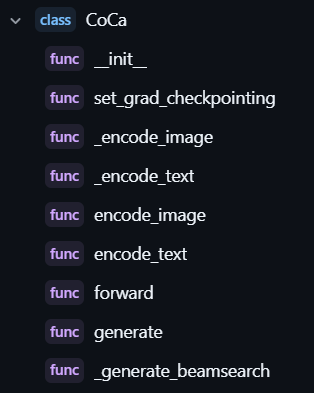

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

A plant with thorns. Its leaves are not acuminate.


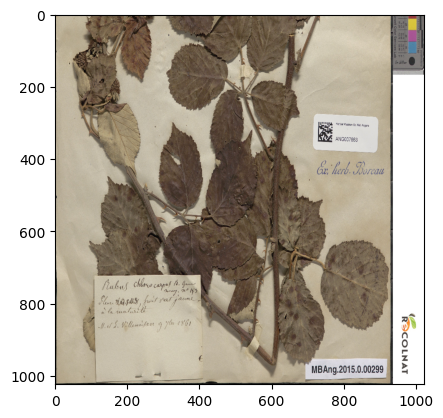

In [ ]:
# take a random image
random_row = random.choice(dataset)
print(random_row[1])
plt.imshow(random_row[0])
plt.show()

In [ ]:
# What can the model say about this image?

img = preprocess(Image.fromarray(random_row[0])).unsqueeze(0).to(device)

with torch.no_grad():
  generated = model.generate(img)

print(open_clip.decode(generated[0]).split("<end_of_text>")[0].replace("<start_of_text>", ""))

a close up of leaves on a piece of paper . 


In [ ]:
images, descriptions = zip(*batches[0])
print("Descriptions:", descriptions)

images = torch.stack([preprocess(Image.fromarray(img)) for img in images]).to(device)
descriptions = tokenizer(descriptions).to(device)
print(f"Images shape: {images.shape}, Descriptions shape: {descriptions.shape}")

out_dict = model.forward(images, descriptions)
print(out_dict)

print("\nOutput:")
for key, value in out_dict.items():
    print(key, value.shape)

Descriptions: ('A plant with thorns. Its leaves are not acuminate.', 'A plant with thorns. Its leaves are acuminate.')
Images shape: torch.Size([2, 3, 224, 224]), Descriptions shape: torch.Size([2, 76])
{'image_features': tensor([[ 0.0105, -0.0019, -0.0267,  ..., -0.0090,  0.0168,  0.0277],
        [-0.0110, -0.0031, -0.0417,  ..., -0.0194,  0.0207,  0.0285]],
       device='cuda:0', grad_fn=<DivBackward0>), 'text_features': tensor([[-0.0190,  0.0289, -0.0316,  ...,  0.0076,  0.0234,  0.0259],
        [-0.0146,  0.0243, -0.0315,  ...,  0.0099,  0.0264,  0.0258]],
       device='cuda:0', grad_fn=<DivBackward0>), 'logits': tensor([[[-6.8313, -0.7279, -2.6190,  ..., -3.3750, -6.8313,  0.0588],
         [-7.0395, -1.9846, -2.6277,  ..., -1.7352, -7.0395, -1.7812],
         [-6.7210, -3.7105, -4.6680,  ..., -5.0548, -6.7210, -0.6447],
         ...,
         [-0.7721, 12.2975, 14.6439,  ...,  0.0211, -0.7721,  8.2426],
         [-0.7796, 12.3061, 14.6487,  ..., -0.1548, -0.7796,  8.1701],
  

Cellules inspirées de [cette page](https://medium.com/aimonks/a-guide-to-fine-tuning-clip-models-with-custom-data-6c7c0d1416fb)

In [23]:
# Adam optimizer with weight decay
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5,betas=(0.9,0.98),eps=1e-6,weight_decay=0.2)

# CoCaLoss
loss = open_clip.CoCaLoss(
    caption_loss_weight=1.0,
    clip_loss_weight=1.0,
)

`loss` est un objet `CoCaLoss`

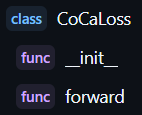 

Est-ce-que c'est une bonne idée de construire de nouveaux batchs à chaque epoch ? Pour qu'une description donnée ne puisse pas correspondre à plusieurs images au sein d'un mini-batch, on est obligé de laisser de côté certaines images. Or ces images laisées de côté lors de la construction d'un mini-batch ne sont pas les mêmes à chaque fois. Cela implique que les images observées changent d'un epoch à l'autre.

In [24]:
# train the model

model.train()

losses = []

batch_size = 2
nb_epochs = 3
for epoch in range(nb_epochs):
    batches, _ = create_batches(train_dataset, train_annotations, batch_size=batch_size)
    pbar = tqdm(batches)
    for batch in pbar:
        images, texts = zip(*batch)
        images = torch.stack([preprocess(Image.fromarray(img)) for img in images])
        texts = tokenizer(texts)
        images = images.to(device)
        texts = texts.to(device)

        optimizer.zero_grad()

        # forward pass
        out_dict = model.forward(images, texts)

        # compute loss
        clip_loss, caption_loss = loss.forward(**out_dict)
        total_loss = clip_loss + caption_loss
        losses.append(total_loss.item())

        # backward pass
        total_loss.backward()

        optimizer.step()
        pbar.set_description(f"Epoch {epoch+1}/{nb_epochs}, Loss: {total_loss.item():.4f}")

  0%|          | 0/35 [00:04<?, ?it/s]


KeyboardInterrupt: 

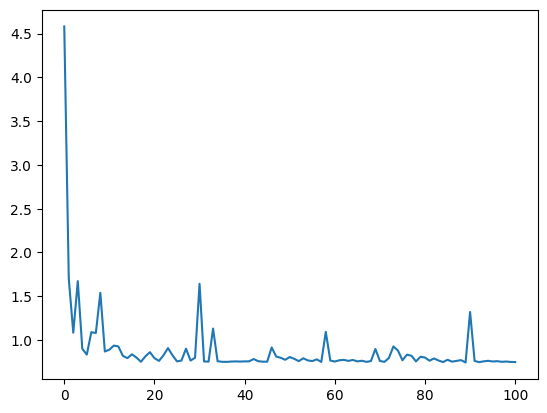

In [46]:
# plot the losses
plt.plot(losses)

In [47]:
# save the model
checkpoint_dir = "checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)
torch.save(model.state_dict(), os.path.join(checkpoint_dir, "CoCa.pth"))

In [48]:
# load the model
model.load_state_dict(torch.load(os.path.join("checkpoints", "CoCa.pth")))

model.eval()

img = preprocess(Image.fromarray(random_row[0])).unsqueeze(0).to(device)
with torch.no_grad():
  generated = model.generate(img)

print(open_clip.decode(generated[0]).split("<end_of_text>")[0].replace("<start_of_text>", ""))

/tmp/ipykernel_22510/3129352795.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join("checkpoints", "CoCa.pth")))


a plant with thorns . its leaves are not acuminate . 


In [87]:
model.eval()  # model in train mode by default, impacts some models with BatchNorm or stochastic depth active

query = "has thorns and round leaves"

descriptions = [sample[1] for sample in test_dataset]
images = [sample[0] for sample in test_dataset]
images = torch.stack([preprocess(Image.fromarray(img)) for img in images]).to(device)

text = tokenizer(query).to(device)

with torch.no_grad():
    image_features = model.encode_image(images)
    text_features = model.encode_text(text)
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)

    image_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)

for i in range(len(descriptions)):
    print(image_probs[i], descriptions[i])

tensor([1.], device='cuda:0') A plant with thorns. Its leaves are not acuminate.
tensor([1.], device='cuda:0') A plant with thorns. Its leaves are not acuminate.
tensor([1.], device='cuda:0') A plant with thorns. Its leaves are not acuminate.
tensor([1.], device='cuda:0') A plant with thorns. Its leaves are not acuminate.
tensor([1.], device='cuda:0') A plant with thorns. Its leaves are acuminate.
tensor([1.], device='cuda:0') A plant with thorns. Its leaves are not acuminate.
tensor([1.], device='cuda:0') A plant with thorns. Its leaves are not acuminate.
tensor([1.], device='cuda:0') A plant with thorns. Its leaves are acuminate.
tensor([1.], device='cuda:0') A plant with thorns. Its leaves are not acuminate.
tensor([1.], device='cuda:0') A plant with thorns. Its leaves are not acuminate.
tensor([1.], device='cuda:0') A plant with thorns. Its leaves are not acuminate.
tensor([1.], device='cuda:0') A plant with thorns. Its leaves are not acuminate.
tensor([1.], device='cuda:0') A plan

### Modèle 2 : Model Soups avec les modèles ViT-B/32 et ViT-B/16

In [10]:
!pip install git+https://github.com/openai/CLIP.git

# !wget https://github.com/Zasder3/model_soups_colab/releases/download/weights/checkpoint_10.1.pt
# !wget https://github.com/Zasder3/model_soups_colab/releases/download/weights/checkpoint_10.2.pt
# !wget https://github.com/Zasder3/model_soups_colab/releases/download/weights/checkpoint_10.3.pt
# !wget https://github.com/Zasder3/model_soups_colab/releases/download/weights/checkpoint_10.4.pt
# !wget https://github.com/Zasder3/model_soups_colab/releases/download/weights/checkpoint_10.5.pt
# !wget https://github.com/Zasder3/model_soups_colab/releases/download/weights/cifar1098_idxs.npy

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-x9d0h3fn
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-x9d0h3fn
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done


In [11]:
import torch
import torch.nn as nn
import os
import random
import torch
from torchvision import transforms
from PIL import Image
from tqdm import tqdm
from matplotlib import pyplot as plt
import clip

# class ModelSoups(nn.Module):
#     def __init__(self, model, feat_dim, num_classes, normalization=True):
#         super(ModelSoups, self).__init__()
#         self.model = model  # Le modèle CLIP ou un autre backbone
#         self.normalization = normalization
        
#         # Classification head
#         self.classification_head = nn.Linear(feat_dim, num_classes)
        
#     def forward(self, images=None, texts=None):
#         if images is not None:
#             features = self.model.encode_image(images)
#         elif texts is not None:
#             features = self.model.encode_text(texts)
#         else:
#             raise ValueError("Vous devez fournir soit des images, soit des textes comme entrée.")

#         if self.normalization:
#             features = features / features.norm(dim=1, keepdim=True)

#         out = {'features': features, 'logits': self.classification_head(features)}
#         return out

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model, preprocess = clip.load("ViT-B/32", device=device)

tokenizer = clip.tokenize

feat_dim = 512
nb_classes = 4
normalization = True
model = model.to(device)

custom_size = 224
# preprocess = transforms.Compose([
#     transforms.Resize(custom_size, interpolation=transforms.InterpolationMode.BICUBIC),
#     transforms.CenterCrop(custom_size),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711)),
# ])

Description A plant with thorns. Its leaves are not acuminate.
positional_embedding: torch.float32
text_projection: torch.float16
logit_scale: torch.float32
visual.class_embedding: torch.float32
visual.positional_embedding: torch.float32
visual.proj: torch.float16
visual.conv1.weight: torch.float16
visual.ln_pre.weight: torch.float32
visual.ln_pre.bias: torch.float32
visual.transformer.resblocks.0.attn.in_proj_weight: torch.float16
visual.transformer.resblocks.0.attn.in_proj_bias: torch.float16
visual.transformer.resblocks.0.attn.out_proj.weight: torch.float16
visual.transformer.resblocks.0.attn.out_proj.bias: torch.float16
visual.transformer.resblocks.0.ln_1.weight: torch.float32
visual.transformer.resblocks.0.ln_1.bias: torch.float32
visual.transformer.resblocks.0.mlp.c_fc.weight: torch.float16
visual.transformer.resblocks.0.mlp.c_fc.bias: torch.float16
visual.transformer.resblocks.0.mlp.c_proj.weight: torch.float16
visual.transformer.resblocks.0.mlp.c_proj.bias: torch.float16
visual

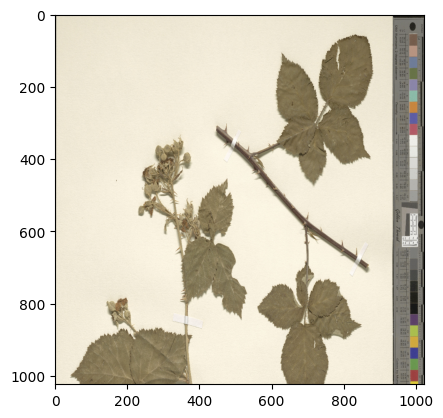

In [13]:
random_row = random.choice(dataset)
print("Description", random_row[1])
plt.imshow(random_row[0])

for name, param in model.named_parameters():
    print(f"{name}: {param.dtype}")

In [14]:
model = model.to(torch.float32)
img = preprocess(Image.fromarray(random_row[0])).unsqueeze(0).to(device)
text = tokenizer(random_row[1]).to(device)
with torch.no_grad():
    logits = model(img, text)
    print("Logits : ", logits)

Logits :  (tensor([[25.7550]], device='cuda:0'), tensor([[25.7550]], device='cuda:0'))


In [15]:
images, descriptions = zip(*batches[0])
print("Descriptions:", descriptions)

images = torch.stack([preprocess(Image.fromarray(img)) for img in images]).to(device)
descriptions = tokenizer(descriptions).to(device)
print(f"Images shape: {images.shape}, Descriptions shape: {descriptions.shape}")

out_dict2 = model.forward(images, descriptions)
logits_per_image, logits_per_text = out_dict2

print(f"logits_per_image shape: {logits_per_image}")
print(f"logits_per_text shape: {logits_per_text}")

# print("\nOutput:")
# print(out_dict2)
# for key, value in out_dict2.items():
#     print(key, value.shape)

Descriptions: ('A plant with thorns. Its leaves are not acuminate.', 'A plant with thorns. Its leaves are acuminate.')
Images shape: torch.Size([2, 3, 224, 224]), Descriptions shape: torch.Size([2, 77])
logits_per_image shape: tensor([[24.3021, 23.9853],
        [24.7504, 24.5479]], device='cuda:0', grad_fn=<MmBackward0>)
logits_per_text shape: tensor([[24.3021, 24.7504],
        [23.9853, 24.5479]], device='cuda:0', grad_fn=<TBackward0>)


In [16]:
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5,betas=(0.9,0.98),eps=1e-6,weight_decay=0.2)
model.train()

losses = []
batch_size = 2
nb_epochs = 3

criterion = torch.nn.CrossEntropyLoss()

In [17]:
for epoch in range(nb_epochs):
    batches, _ = create_batches(train_dataset, train_annotations, batch_size=batch_size)
    pbar = tqdm(batches)
    for batch in pbar:
        images, texts = zip(*batch)
        images = torch.stack([preprocess(Image.fromarray(img)) for img in images])
        texts = tokenizer(texts)
        images = images.to(device)
        texts = texts.to(device)
        
        optimizer.zero_grad()

        # Forward pass
        logits_per_image, logits_per_text = model(images, texts)

        # Calcul de la perte (contraste entre logits image et texte)
        ground_truth = torch.arange(len(images), dtype=torch.long, device=device)  # Labels : 0, 1, 2, ...
        loss = (criterion(logits_per_image, ground_truth) + criterion(logits_per_text, ground_truth)) / 2
        losses.append(loss.item())

        # Backward pass
        loss.backward()
        optimizer.step()

        pbar.set_description(f"Epoch {epoch+1}/{nb_epochs}, Loss: {loss.item():.4f}")

Epoch 3/3, Loss: 0.6937: 100%|██████████| 38/38 [00:06<00:00,  6.03it/s]


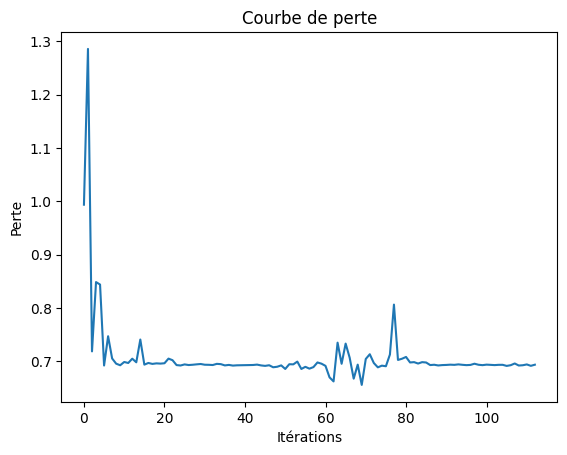

In [18]:
# Visualiser les pertes
plt.plot(losses)
plt.xlabel("Itérations")
plt.ylabel("Perte")
plt.title("Courbe de perte")
plt.show()

In [19]:
# Sauvegarder le modèle
checkpoint_dir = "checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)
torch.save(model.state_dict(), os.path.join(checkpoint_dir, "ModelSoups.pth"))

# Recharger le modèle
model.load_state_dict(torch.load(os.path.join("checkpoints", "ModelSoups.pth")))
model.eval()

/tmp/ipykernel_36566/735014450.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join("checkpoints", "ModelSoups.pth")))


CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          

In [20]:
model.eval()  # Passer le modèle en mode évaluation

query = "A plant with thorns and leaves are round"  # Requête textuelle

# Extraction des descriptions et des images depuis le jeu de test
descriptions = [sample[1] for sample in test_dataset]
images = [sample[0] for sample in test_dataset]

# Prétraitement des images
images = torch.stack([preprocess(Image.fromarray(img)) for img in images]).to(device)

# Tokenisation de la requête textuelle
text = tokenizer(query).to(device)

# Encodage des images et du texte avec CLIP
with torch.no_grad():
    # Encodage des images et du texte
    image_features = model.encode_image(images)
    text_features = model.encode_text(text)
    
    # Normalisation des features pour calculer les similarités cosinus
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    
    # Calcul des similarités entre les images et la requête textuelle
    image_probs = (100.0 * image_features @ text_features.T).softmax(dim=0)

# Affichage des résultats
print("\nRésultats de la recherche :")
sorted_indices = torch.argsort(image_probs.squeeze(), descending=True)
for idx in sorted_indices:
    print(f"Probabilité : {image_probs[idx].item():.4f}, Description : {descriptions[idx]}")


Résultats de la recherche :
Probabilité : 0.0266, Description : A plant with thorns. Its leaves are not acuminate.
Probabilité : 0.0265, Description : A plant with thorns. Its leaves are not acuminate.
Probabilité : 0.0263, Description : A plant with thorns. Its leaves are not acuminate.
Probabilité : 0.0257, Description : A plant with thorns. Its leaves are not acuminate.
Probabilité : 0.0256, Description : A plant with thorns. Its leaves are not acuminate.
Probabilité : 0.0255, Description : A plant with thorns. Its leaves are not acuminate.
Probabilité : 0.0255, Description : A plant with thorns. Its leaves are acuminate.
Probabilité : 0.0254, Description : A plant with thorns. Its leaves are not acuminate.
Probabilité : 0.0254, Description : A plant with thorns. Its leaves are not acuminate.
Probabilité : 0.0253, Description : A plant with thorns. Its leaves are not acuminate.
Probabilité : 0.0252, Description : A plant with thorns. Its leaves are not acuminate.
Probabilité : 0.02

In [ ]:
import torch
import torch.nn as nn
import clip
from PIL import Image
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Charger plusieurs modèles CLIP
def load_multiple_models(model_names, device):
    models = []
    preprocessors = []
    
    for model_name in model_names:
        model, preprocess = clip.load(model_name, device=device)
        models.append(model)
        preprocessors.append(preprocess)
    
    return models, preprocessors

# Ajouter une couche de projection pour uniformiser la taille des embeddings
def create_projection_layer(input_dim, output_dim):
    return nn.Linear(input_dim, output_dim)

# Encodage des images avec plusieurs modèles et projection des embeddings dans un espace commun
def encode_with_multiple_models(models, image, text, projection_layer, alpha=None):
    image_features = []
    text_features = []

    # S'assurer que la projection est sur le même appareil que les tensors
    projection_layer = projection_layer.to(device)

    for model in models:
        # Encodage de l'image et du texte
        image_feats = model.encode_image(image)
        text_feats = model.encode_text(text)
        
        # Déplacer les tensors sur le même appareil que le modèle et la projection
        image_feats = image_feats.to(device).float()
        text_feats = text_feats.to(device).float()
        
        # Appliquer la projection pour harmoniser la dimension
        image_feats = projection_layer(image_feats)
        text_feats = projection_layer(text_feats)
        
        
        # Ajouter les embeddings projetés à la liste
        image_features.append(image_feats)
        text_features.append(text_feats)

    # Combiner les embeddings projetés avec des pondérations
    if alpha is None:
        alpha = [1.0 / len(models)] * len(models)

    combined_image_features = sum(alpha[i] * image_features[i] for i in range(len(image_features)))
    combined_text_features = sum(alpha[i] * text_features[i] for i in range(len(text_features)))

    return combined_image_features, combined_text_features


# Créer un modèle "soupe" avec des poids combinés et une projection
def create_model_soup(models, projection_layer, alpha=None, device="cuda"):
    model, preprocess = clip.load("ViT-B/32", device=device)  # Charger un modèle de base (viT-B/32)
    model = model.to(device)
    
    return model, preprocess

def create_projection_layer(input_dim, output_dim):
    return nn.Linear(input_dim, output_dim)

# Paramètres du modèle
model_names = ["ViT-B/32", "ViT-B/16"]  # Liste de modèles à combiner
models, preprocessors = load_multiple_models(model_names, device=device)

# Exemple des dimensions d'entrée des modèles
input_dim = 512  # Taille des embeddings sortants de ViT-B/32 et ViT-B/16
output_dim = 512  # Taille de sortie après projection (à adapter si nécessaire)

# Créer une couche de projection pour harmoniser les dimensions
projection_layer = create_projection_layer(input_dim, output_dim)  # Projection de 512 vers 512

# Exemple d'utilisation avec des images et des descriptions
def process_image(image_path):
    img = Image.open(image_path)
    img = preprocessors[0](img).unsqueeze(0).to(device)  # Prétraitement de l'image
    return img

def process_text(text):
    text = clip.tokenize([text]).to(device)  # Tokenisation du texte
    return text

# Exemple de requête et de test
image_pathes = ["images/ANG015892.jpg", "images/ANG000419.jpg"]  # [La plante a des épines mais des feuilles non acuminées, La plante a des épines et des feuilles acuminées]
images = [process_image(image_path) for image_path in image_pathes]
# Exemple de requêtes
queries = ["the plant has thorns and acuminate leaves",
           "the plant has thorns and its leaves are not acuminate",
           "the plant doesn't have thorns and its leaves are not acuminate",
           "there's white chocolate on the table",
           "dinner is served on a golden plate"
           ]
texts = [process_text(query) for query in queries]

# Encodage des textes
for image in images:
    with torch.no_grad():
        text_features = []
        for text in texts:
            _, combined_text_features = encode_with_multiple_models(models, image, text, projection_layer, alpha=[0.5, 0.5])
            combined_text_features /= combined_text_features.norm(dim=-1, keepdim=True)  # Normalisation
            text_features.append(combined_text_features)

        text_features = torch.cat(text_features, dim=0)  # Empiler tous les embeddings de texte

        # Normalisation de l'image
        combined_image_features, _ = encode_with_multiple_models(models, image, text, projection_layer, alpha=[0.5, 0.5])
        combined_image_features /= combined_image_features.norm(dim=-1, keepdim=True)  # Normalisation

        # Calcul des similarités
        similarities = 100.0 * combined_image_features @ text_features.T
        probabilities = similarities.softmax(dim=-1)  # Calcul des probabilités

    # Affichage des résultats
    for i, query in enumerate(queries):
        print(f"Query: {query} - Probabilité : {probabilities[0, i].item():.4f}")


Query: the plant has thorns and acuminate leaves - Probabilité : 0.3141
Query: the plant has thorns and its leaves are not acuminate - Probabilité : 0.5611
Query: the plant doesn't have thorns and its leaves are not acuminate - Probabilité : 0.1246
Query: there's white chocolate on the table - Probabilité : 0.0001
Query: dinner is served on a golden plate - Probabilité : 0.0000
Query: the plant has thorns and acuminate leaves - Probabilité : 0.5645
Query: the plant has thorns and its leaves are not acuminate - Probabilité : 0.2973
Query: the plant doesn't have thorns and its leaves are not acuminate - Probabilité : 0.1381
Query: there's white chocolate on the table - Probabilité : 0.0001
Query: dinner is served on a golden plate - Probabilité : 0.0001
